In [1]:
%matplotlib inline

import cv2
import os
import numpy as np

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
class ImageAnalyser:
    def __init__(self, path_to_img):
        self.path_to_img = path_to_img
        self.colored_img = self.read()
        # needed as opencv read image in BGR format
        self.convert_from_bgr_to_rgb()
        self.gray_img = self.convert_img_to_gray().astype(np.uint8)

    # read image by path
    def read(self) -> np.ndarray:
        return cv2.imread(self.path_to_img)
    
    def get_Ks(self):
        file_size = os.path.getsize(self.path_to_img)
        bpp = 8 if img.dtype == 'uint8' else 16
        Ks = ((self.colored_img.shape[0] * self.colored_img.shape[1] * bpp) / 8) / file_size
        
        print(f"Image {self.path_to_img} : shape = {self.colored_img.shape}; image size = {file_size}; Ks = {Ks}")
        
        return Ks
    
    def convert_from_bgr_to_rgb(self):
        b, g, r = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        
        rgb_img = np.zeros_like(self.colored_img)
        rgb_img[:, :, 0] = r
        rgb_img[:, :, 1] = g
        rgb_img[:, :, 2] = b
        
        self.colored_img = rgb_img
        
    def convert_from_rgb_to_bgr(self):
        r, g, b = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        
        bgr_img = np.zeros_like(self.colored_img)
        bgr_img[:, :, 0] = b
        bgr_img[:, :, 1] = g
        bgr_img[:, :, 2] = r
        
        return bgr_img
        
    # converts image to grayscale
    def convert_img_to_gray(self) -> np.ndarray:
        r, g, b = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        gray_img = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray_img

    # return array of 8 binary planes of gray image
    def get_binary_planes(self):
        resize_to = self.gray_img.shape

        out = self.gray_img.reshape(resize_to[0] * resize_to[1])

        vfunc = np.vectorize(lambda x: f"{np.binary_repr(x, width=8)}")

        out = vfunc(out)
        
        planes = []

        curr_i = 1
        for i in range(8):
            bit_img = (np.array([int(j[7 - i]) for j in out], dtype=np.uint8) * curr_i).reshape(resize_to)
            curr_i *= 2
            planes.append(bit_img)

        return planes
    
    def binary_image(self, threshold):
        value = 255 * threshold / 100
        threshold_image = self.gray_img.copy()
        threshold_image[threshold_image < value] = 0
        threshold_image[threshold_image >= value] = 255
        return threshold_image

    def discrete(self, kernel_size):

        count_of_kernels = (self.gray_img.shape[0] // kernel_size) ** 2

        resized = self.gray_img.reshape((count_of_kernels, kernel_size, kernel_size))

        out = np.zeros_like(resized)

        for i in range(out.shape[0]):
            out[i].fill(np.mean(resized[i]))

        return np.array(out.flatten()).reshape(self.gray_img.shape).astype(np.uint8)

    def quant(self, level):
        lev = 256 // level

        vfunc = np.vectorize(lambda x: (x // lev) * lev)

        return np.array(vfunc(self.gray_img)).astype(np.uint8)

    def get_mean_brightness(self):
        return np.mean(self.gray_img)

    def get_4_neighbour(self, p1=(21, 17)):
        arr = [self.gray_img[p1[0] + 1][p1[0]], self.gray_img[p1[0]][p1[0] + 1], self.gray_img[p1[0] - 1][p1[0]],
               self.gray_img[p1[0]][p1[0] - 1]]
        return arr

    def get_diag_4_neighbour(self, p2=(15, 11)):

        arr = [self.gray_img[p2[0] + 1][p2[0] + 1], self.gray_img[p2[0] - 1][p2[0] - 1],
               self.gray_img[p2[0] + 1][p2[0] - 1], self.gray_img[p2[0] - 1][p2[0] + 1]]

        return arr

    def get_8_neighbour(self, p3=(19, 88)):

        arr1 = self.get_4_neighbour(p3)
        arr2 = self.get_diag_4_neighbour(p3)

        return arr1 + arr2

    def crop_center(self):

        center = self.gray_img.shape[0] // 2, self.gray_img.shape[1] // 2

        cropped = self.gray_img[center[0] - 50: center[0] + 50, center[1] - 50: center[1] + 50]

        return cropped

    def add_marks(self):

        out = self.gray_img.copy()

        mean_bright = self.get_mean_brightness()

        color = 255 if mean_bright < 128 else 0

        center = self.gray_img.shape[0] // 2, self.gray_img.shape[1] // 2

        for i in range(20):
            for j in range(20):
                out[i][j] = color
                out[out.shape[0] - i - 1][out.shape[1] - j - 1] = color
                out[out.shape[0] - i - 1][j] = color
                out[i][out.shape[1] - j - 1] = color
                out[center[0] - 10 + i][center[1] - 10 + j] = color

        return out

### 2

Read image

In [3]:
global_path = "/home/julia/Desktop/DIP/lab1"
file_name = "cat"

image_analyser = ImageAnalyser(f"{global_path}/{file_name}.jpg")
img = image_analyser.read()

### 3

Show image

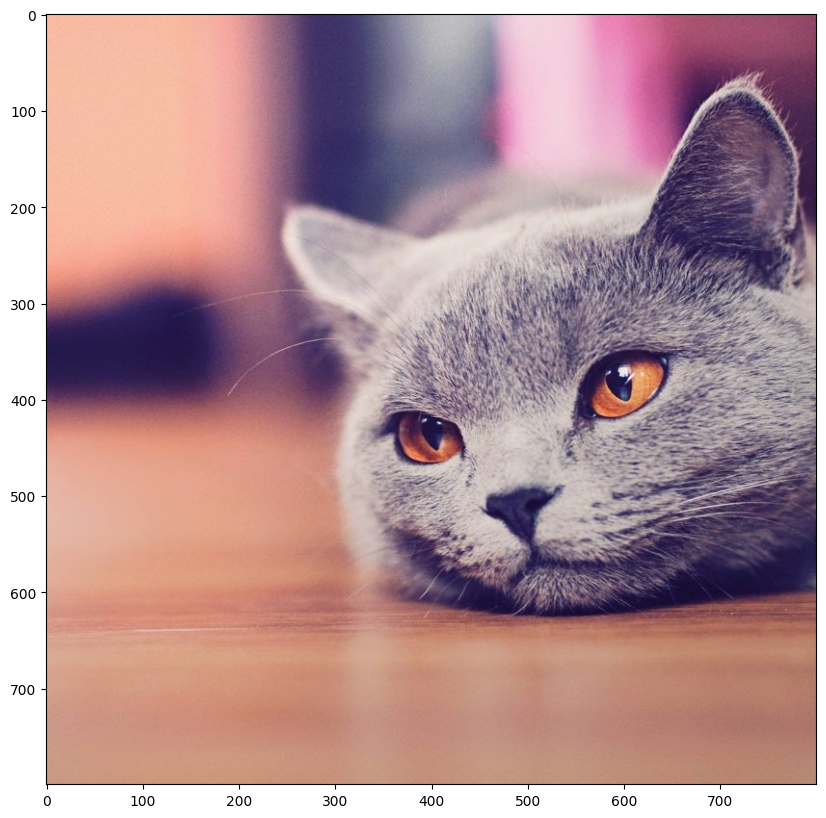

In [4]:
plt.imshow(image_analyser.colored_img)
plt.show()

### 4 and 5

Save png and jpg image

In [5]:
cv2.imwrite(f"{global_path}/{file_name}_out.png", image_analyser.convert_from_rgb_to_bgr())
cv2.imwrite(f"{global_path}/{file_name}_out.jpg", image_analyser.convert_from_rgb_to_bgr())

True

In [6]:
files_in_dir = list(filter(lambda s: "out" in s, os.listdir(global_path)))

print(files_in_dir)

['cat_out.png', 'cat_out.jpg']


In [7]:
analysers = []

for file in files_in_dir:
    img = cv2.imread(file)
    
    img_analyser = ImageAnalyser(f"{global_path}/{file}")
    img = img_analyser.read()
    gray_img = img_analyser.convert_img_to_gray()
    
    analysers.append(img_analyser)

### 6 and 7
Get info about images and get comprensation coefficient

In [8]:
for analyser in analysers:
    analyser.get_Ks()

Image /home/julia/Desktop/DIP/lab1/cat_out.png : shape = (800, 800, 3); image size = 883267; Ks = 0.7245827139471983
Image /home/julia/Desktop/DIP/lab1/cat_out.jpg : shape = (800, 800, 3); image size = 157996; Ks = 4.050735461657257


### 8 
Convert to grayscale, show and save

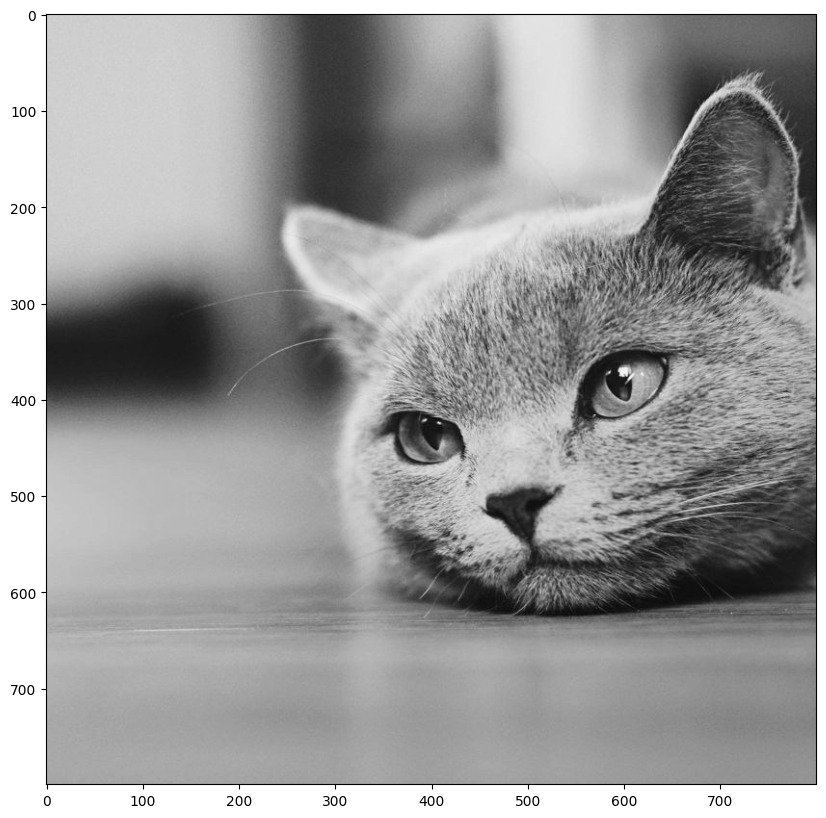

In [9]:
gray = image_analyser.convert_img_to_gray()
plt.imshow(gray, cmap='gray')
cv2.imwrite(f"{global_path}/gray.png", gray)
plt.show()

In [10]:
def plot_array_of_images(values, path_to_write, f):
    fig, axes = plt.subplots(1, len(values))
    for i, value in enumerate(values):
        binary = f(value)
        axes[i].imshow(binary, cmap='gray')
        axes[i].set_title(f"{value}")
        axes[i].set_axis_off()
        cv2.imwrite(f"{global_path}/{path_to_write}/cat_{value}.png", binary)
plt.show()

### 9
Conver to discrete image, show and save

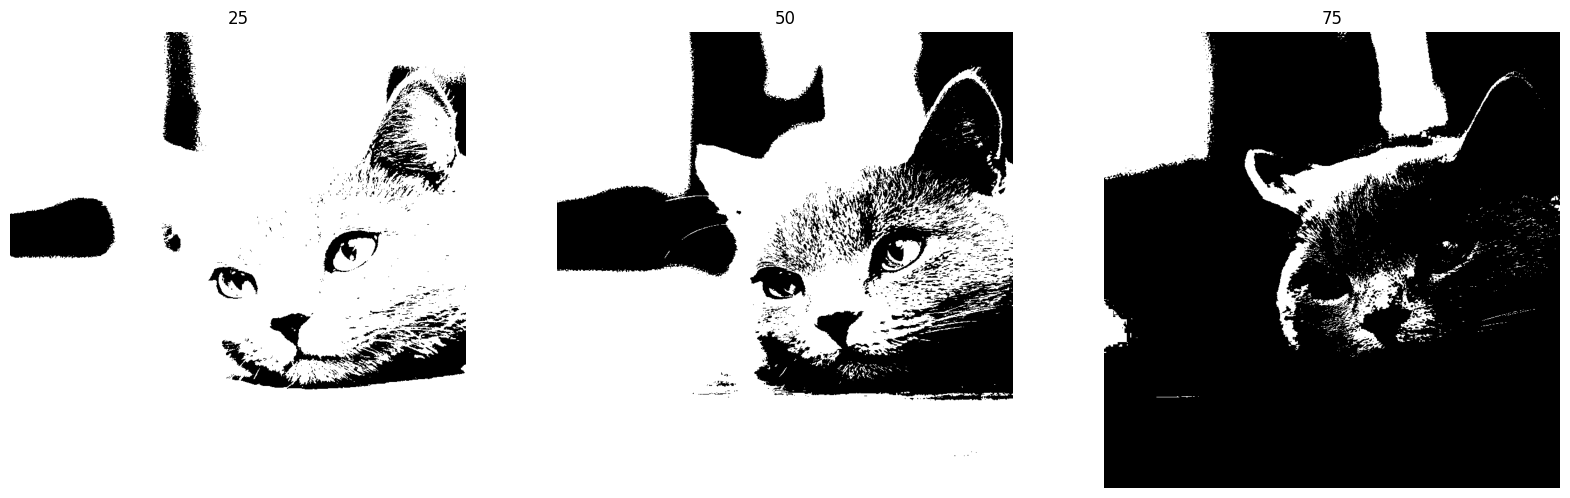

In [11]:
thresholds = [25, 50, 75]

plot_array_of_images(thresholds, "Logical", image_analyser.binary_image)

### 10
Bit planes

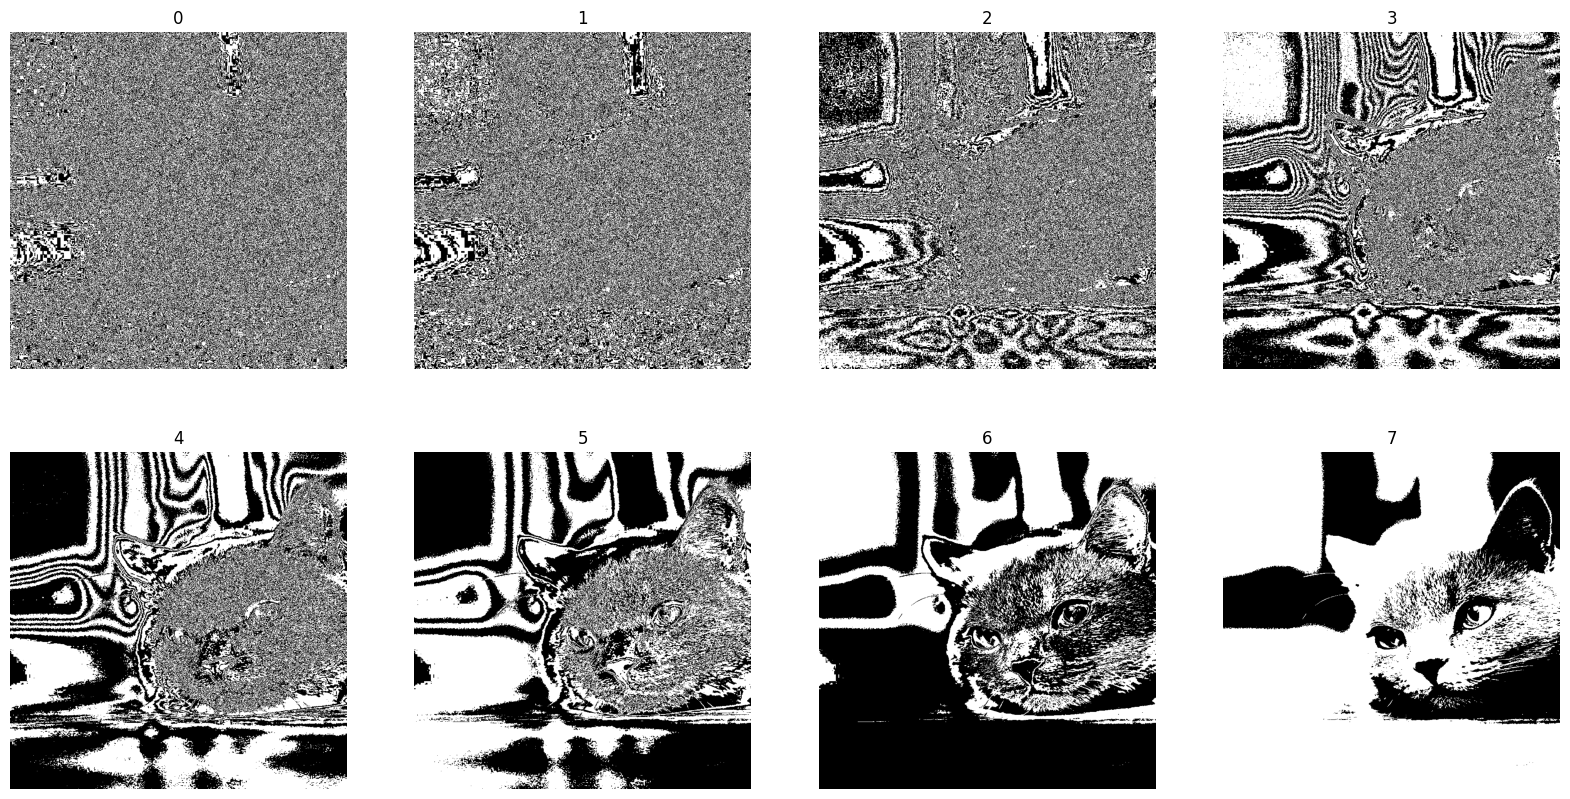

In [12]:
planes = image_analyser.get_binary_planes()
fig, axes = plt.subplots(2, 4)

for i, value in enumerate(planes):
    axes[i//4, i%4].imshow(value, cmap='gray')
    axes[i//4, i%4].set_title(f"{i}")
    axes[i//4, i%4].set_axis_off()
    cv2.imwrite(f"{global_path}/Planes/cat_{i}.png", value)
    
plt.show()

### 11
Discret images

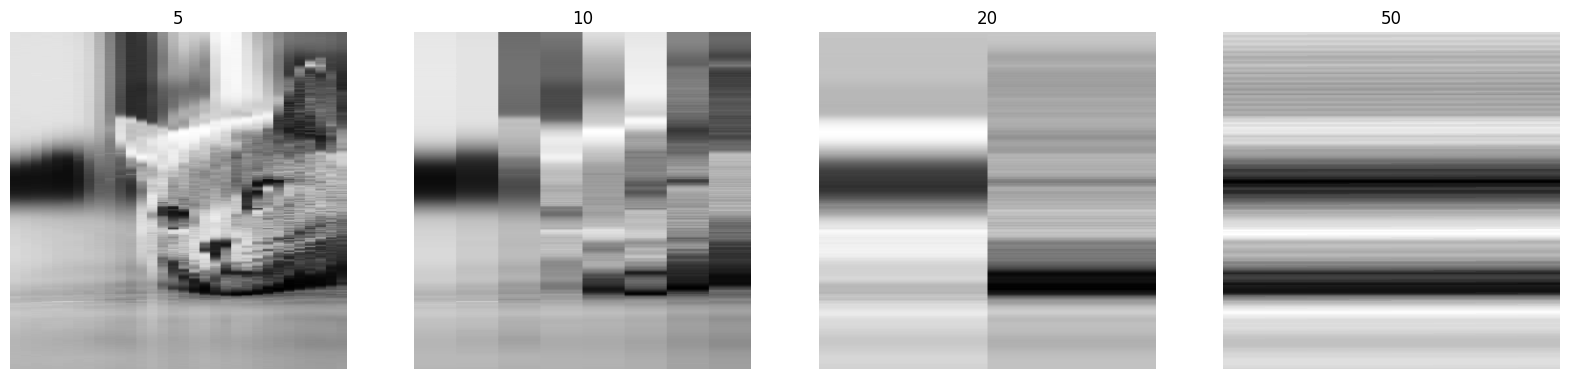

In [13]:
discretes = [5, 10, 20, 50]

plot_array_of_images(discretes, "Discret", image_analyser.discrete)

### 12
Quantization

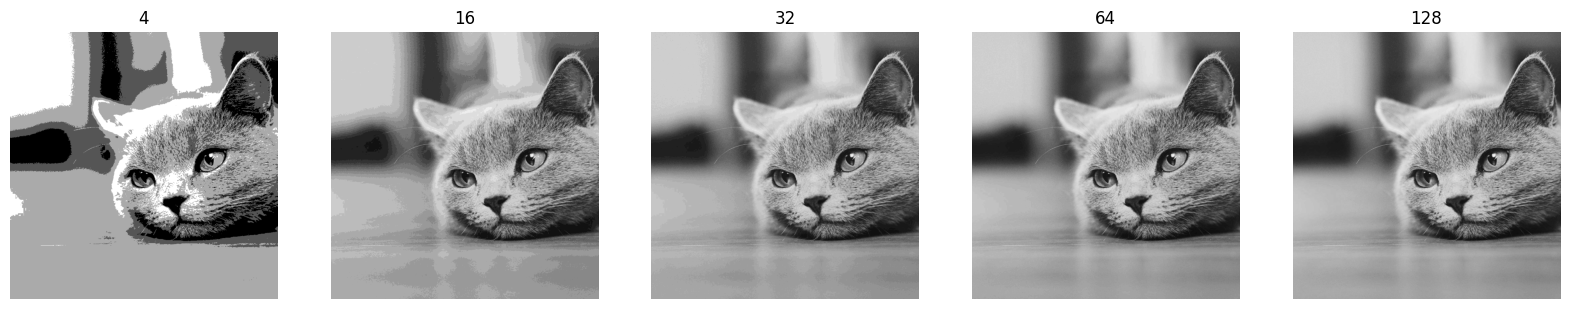

In [14]:
grades = [4, 16, 32, 64, 128]

plot_array_of_images(grades, "Discret", image_analyser.quant)

### 13
Crop center

True

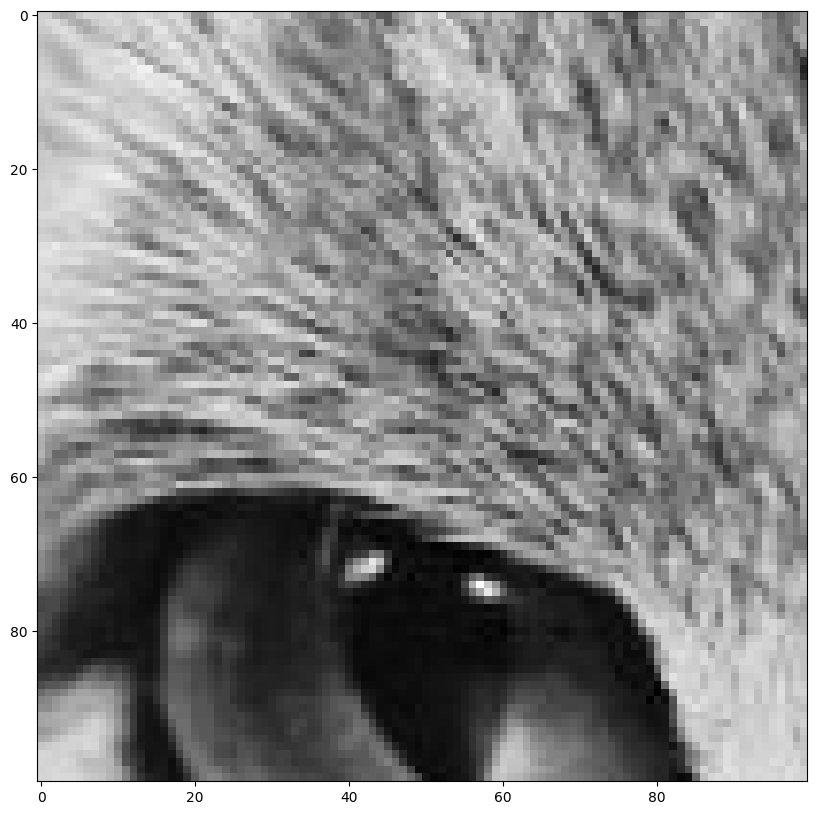

In [15]:
center = image_analyser.gray_img.shape[0] // 2, image_analyser.gray_img.shape[1] // 2

cropped = image_analyser.gray_img[center[0] - 50: center[0] + 50, center[1] - 50: center[1] + 50]

plt.imshow(cropped, cmap="gray")
cv2.imwrite(f"{global_path}/Crop/Cropped.png", cropped)

### 14
4 neighbours

In [16]:
image_analyser.get_4_neighbour()

[201, 201, 201, 200]

4 diagonal neighbours

In [17]:
image_analyser.get_diag_4_neighbour()

[203, 199, 200, 203]

8 neighbours

In [18]:
image_analyser.get_8_neighbour()

[201, 201, 202, 202, 200, 202, 201, 202]

### 15
Get mean brightness

In [19]:
image_analyser.get_mean_brightness()

142.4660546875

True

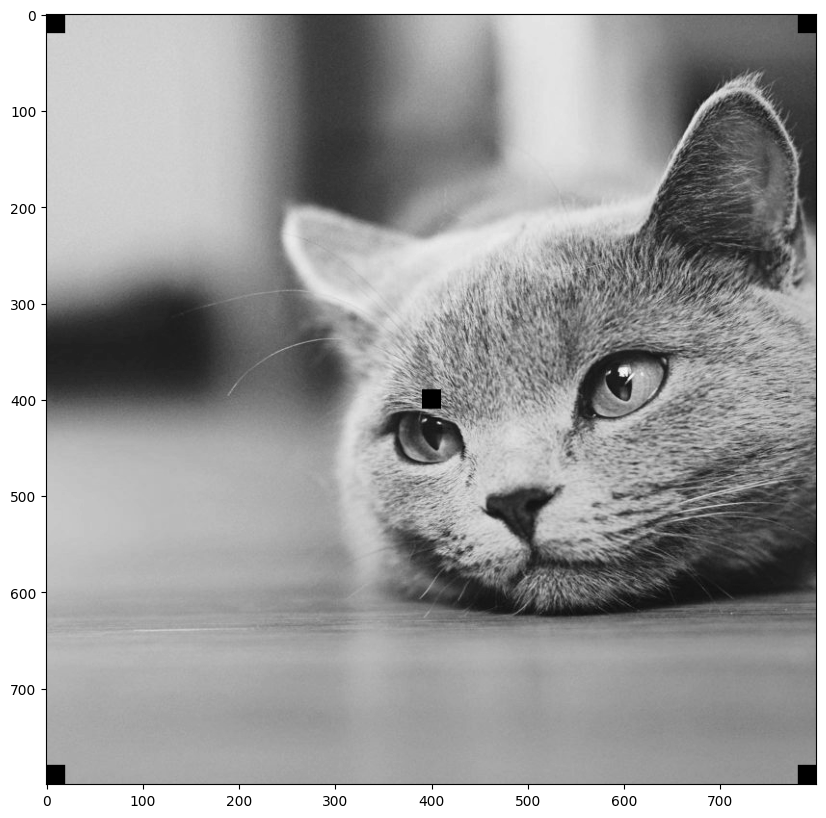

In [20]:
marked = image_analyser.add_marks()

plt.imshow(marked, cmap="gray")
cv2.imwrite(f"{global_path}/Marks/marked.png", marked)